<a href="https://colab.research.google.com/github/mesternandi2004/Trump_Tweets_Analysis/blob/main/Trumph_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**🇺🇸 Trump Twitter Analysis: Populist Discourse & Social Media**

**Date:** December 2025  
**Project:** Bachelor's Thesis - Political Communication Analysis



# 1. Project Overview


This analysis investigates **populist rhetoric patterns** in Donald Trump's Twitter communication using:
- **Unsupervised Machine Learning** (no predefined categories)
- **Natural Language Processing** (NLP)
- **Topic Modeling** (BERTopic, Word2Vec)


#  Methodology

 - **Word2Vec + K-Means Clustering** → Discover word-level semantic groups
 - **BERTopic** → Identify tweet-level themes automatically
 - **Temporal Analysis** → Track discourse shifts over time
 - **Engagement Analysis** → Measure impact by likes/retweets

#  2. Research Questions

# Primary Research Questions

**RQ1:** What are the most frequently used words in Trump's Twitter communication?

**RQ2:** What semantic clusters emerge from word-level analysis without predefined categories?

**RQ3:** What thematic topics can be identified in complete tweets using unsupervised learning?

**RQ4:** How do populist discourse patterns change over time (2016 campaign vs. presidency vs. COVID-19)?

**RQ5:** Which discourse categories generate the highest engagement (likes, retweets)?

 ### Hypotheses

**H1:** "Enemy" narratives (media, opposition) will dominate word frequencies.

**H2:** Crisis periods (COVID-19, impeachment) will show increased conspiracy and attack rhetoric.

**H3:** Campaign periods will exhibit higher national identity and polarization themes.

# Setup & Installation



In [2]:
# Install Missing Packages
!pip install gensim
!pip install bertopic


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 3.9 MB/s eta 0:00:00


In [3]:


# Import Libraries
import pandas as pd
import numpy as np
import re
import html
import warnings
from pathlib import Path
from collections import Counter, defaultdict
from datetime import datetime

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Machine Learning
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# BERTopic
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Settings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# NLTK downloads
try:
    nltk.download('stopwords', quiet=True)
    nltk.download('punkt', quiet=True)
except:
    pass


/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.



# Create directory structure

In [5]:
def create_project_structure():
    """Create necessary folders"""
    folders = [
        'data/raw',
        'data/processed',
        'outputs/visualizations',
        'outputs/models'
    ]
    for folder in folders:
        Path(folder).mkdir(parents=True, exist_ok=True)

create_project_structure()

# 3. Data Loading & Cleaning

# Dataset Information

- **Source:** Trump Twitter Archive (2009-2021)
- **Original Size:** ~57,000 tweets
- **Time Period:** Pre-campaign → Presidency → Post-ban
- **Columns:** id, text, date, favorites, retweets, isDeleted, isRetweet


# Load Data

In [7]:
df = pd.read_csv('/tweets_01-08-2021.csv')

print(f"Original dataset: {len(df):,} tweets")
print(f"Columns: {list(df.columns)}")
print(f"Date range: {df['date'].min()} → {df['date'].max()}")
print("\nFirst tweet:")
print(df.iloc[0]['text'][:200], "...")

Original dataset: 56,571 tweets
Columns: ['id', 'text', 'isRetweet', 'isDeleted', 'device', 'favorites', 'retweets', 'date', 'isFlagged']
Date range: 2009-05-04 18:54:25 → 2021-01-08 15:44:28

First tweet:
Republicans and Democrats have both created our economic problems. ...


# Data Cleaning Pipeline

# Steps:
 1. Remove deleted tweets
 2. Remove retweets (not original content)
 3. Fix encoding issues (UTF-8 problems)
 4. Parse dates
 5. Remove empty tweets
 6. Text preprocessing (tokenization, stopwords)



In [8]:
def fix_encoding_issues(text):
    """Fix UTF-8 encoding problems"""
    if not isinstance(text, str):
        return ""

    text = html.unescape(text)

    replacements = {
        'â€¦': '...', 'â€™': "'", 'â€œ': '"',
        'â€': '"', 'â€"': '-', 'Â': ''
    }

    for old, new in replacements.items():
        text = text.replace(old, new)

    return text


def clean_text(text, remove_stopwords=True, min_word_length=2):
    """
    Advanced text cleaning

    Returns: list of cleaned tokens
    """
    # Fix encoding
    text = fix_encoding_issues(text)

    # Lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove mentions
    text = re.sub(r'@\w+', '', text)

    # Remove RT marker
    text = re.sub(r'\brt\b', '', text)

    # Remove # but keep word
    text = re.sub(r'#(\w+)', r'\1', text)

    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove special characters (keep letters only)
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenize
    try:
        tokens = word_tokenize(text)
    except:
        tokens = text.split()

    # Remove stopwords
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        custom_stopwords = {
            'https', 'http', 'rt', 'amp', 'co', 'will',
            'just', 'like', 'get', 'would', 'could', 'one',
            'us', 'much', 'many', 'even', 'also', 'said',
            'say', 'may', 'going', 'new', 'today', 'see'
        }
        stop_words.update(custom_stopwords)

        tokens = [
            word for word in tokens
            if word not in stop_words
            and len(word) >= min_word_length
            and word.isalpha()
        ]

    return tokens


# 1. Remove deleted tweets
initial_count = len(df)
df = df[df['isDeleted'] == 'f'].copy()
print(f"After removing deleted: {len(df):,} ({initial_count - len(df)} removed)")

# 2. Parse dates
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date'])

# 3. Remove retweets
df['is_retweet'] = df['text'].str.startswith('RT @', na=False)
retweet_count = df['is_retweet'].sum()
df = df[~df['is_retweet']].copy()
print(f"After removing retweets: {len(df):,} ({retweet_count} removed)")

# 4. Remove NaN texts
df = df.dropna(subset=['text'])

# 5. Store original text
df['text_original'] = df['text']

# 6. Clean text
df['cleaned_tokens'] = df['text'].apply(clean_text)
df['cleaned_text'] = df['cleaned_tokens'].apply(lambda x: ' '.join(x))
df['word_count'] = df['cleaned_tokens'].apply(len)

# 7. Remove empty tweets
empty_count = (df['word_count'] == 0).sum()
df = df[df['word_count'] > 0].copy()
print(f"After removing empty: {len(df):,} ({empty_count} removed)")

# 8. Extract temporal features
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['year_month'] = df['date'].dt.to_period('M')
df['day_of_week'] = df['date'].dt.day_name()

# 9. Create period labels
def assign_period(date):
    if date < pd.Timestamp('2016-06-16'):
        return 'Pre-Campaign'
    elif date < pd.Timestamp('2017-01-20'):
        return 'Campaign 2016'
    elif date < pd.Timestamp('2020-01-01'):
        return 'Presidency (Pre-COVID)'
    elif date < pd.Timestamp('2020-11-03'):
        return 'COVID & Election 2020'
    else:
        return 'Post-Election'

df['period'] = df['date'].apply(assign_period)

print(f"\n✅ Final dataset: {len(df):,} tweets")
print(f"Date range: {df['date'].min().date()} → {df['date'].max().date()}")
print(f"Average words per tweet: {df['word_count'].mean():.1f}")

# %%
# Save cleaned data
df.to_csv('data/processed/tweets_cleaned.csv', index=False)
print("💾 Saved: data/processed/tweets_cleaned.csv")

# Display sample
print("\n📋 Sample cleaned tweets:")
for i in range(3):
    print(f"\n[{i+1}] ORIGINAL:")
    print(df.iloc[i]['text_original'][:150])
    print(f"\n[{i+1}] CLEANED:")
    print(df.iloc[i]['cleaned_text'][:150])
    print("-" * 80)


🧹 Cleaning data...
After removing deleted: 55,479 (1092 removed)
After removing retweets: 46,340 (9139 removed)
After removing empty: 44,899 (1441 removed)

✅ Final dataset: 44,899 tweets
Date range: 2009-05-04 → 2021-01-08
Average words per tweet: 10.0
💾 Saved: data/processed/tweets_cleaned.csv

📋 Sample cleaned tweets:

[1] ORIGINAL:
Republicans and Democrats have both created our economic problems.

[1] CLEANED:
republicans democrats created economic problems
--------------------------------------------------------------------------------

[2] ORIGINAL:
I was thrilled to be back in the Great city of Charlotte, North Carolina with thousands of hardworking American Patriots who love our Country, cherish

[2] CLEANED:
thrilled back great city charlotte north carolina thousands hardworking american patriots love country cherish values respect laws always put america 
--------------------------------------------------------------------------------

[3] ORIGINAL:
The Unsolicited Mail In B

#  4️. Exploratory Data Analysis

# Basic Statistics
Descriptive Statistics




Total Tweets............................               44,899
Date Range.............................. 2009-05-04 → 2021-01-08
Total Words.............................              447,315
Unique Words............................               27,057
Avg Words/Tweet.........................                 10.0
Median Words/Tweet......................                    9
Total Favorites.........................        1,487,704,641
Total Retweets..........................          342,486,359
Avg Favorites...........................                33134
Avg Retweets............................                 7628

📅 Tweets by Period:
period
COVID & Election 2020      4438
Campaign 2016              2031
Post-Election               796
Pre-Campaign              27976
Presidency (Pre-COVID)     9658
Name: count, dtype: int64

📅 Tweets by Year:
year
2009      56
2010     142
2011     772
2012    3516
2013    8087
2014    5768
2015    7486
2016    4046
2017    2261
2018    2972
2019    4

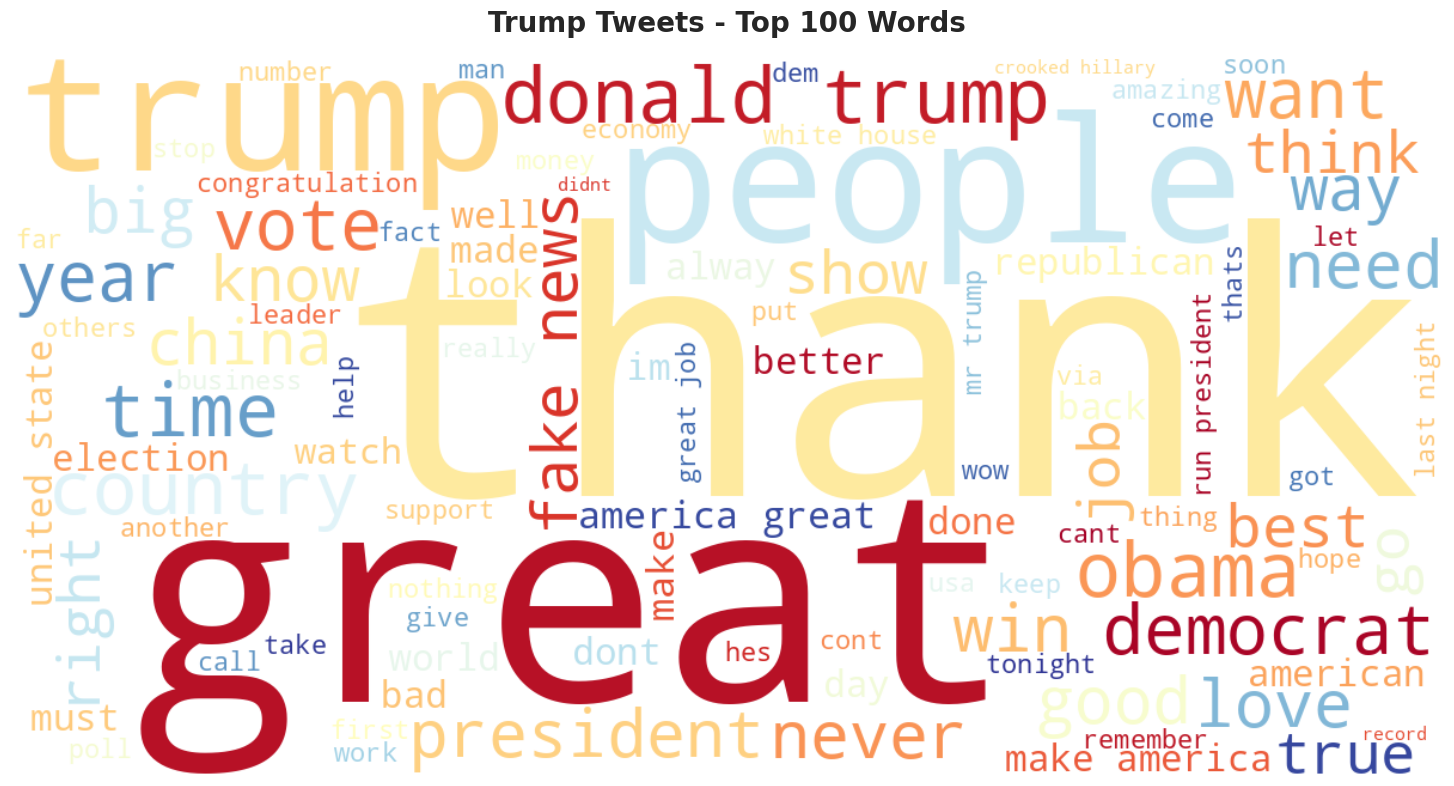

💾 Saved: outputs/visualizations/top_words_bar.png


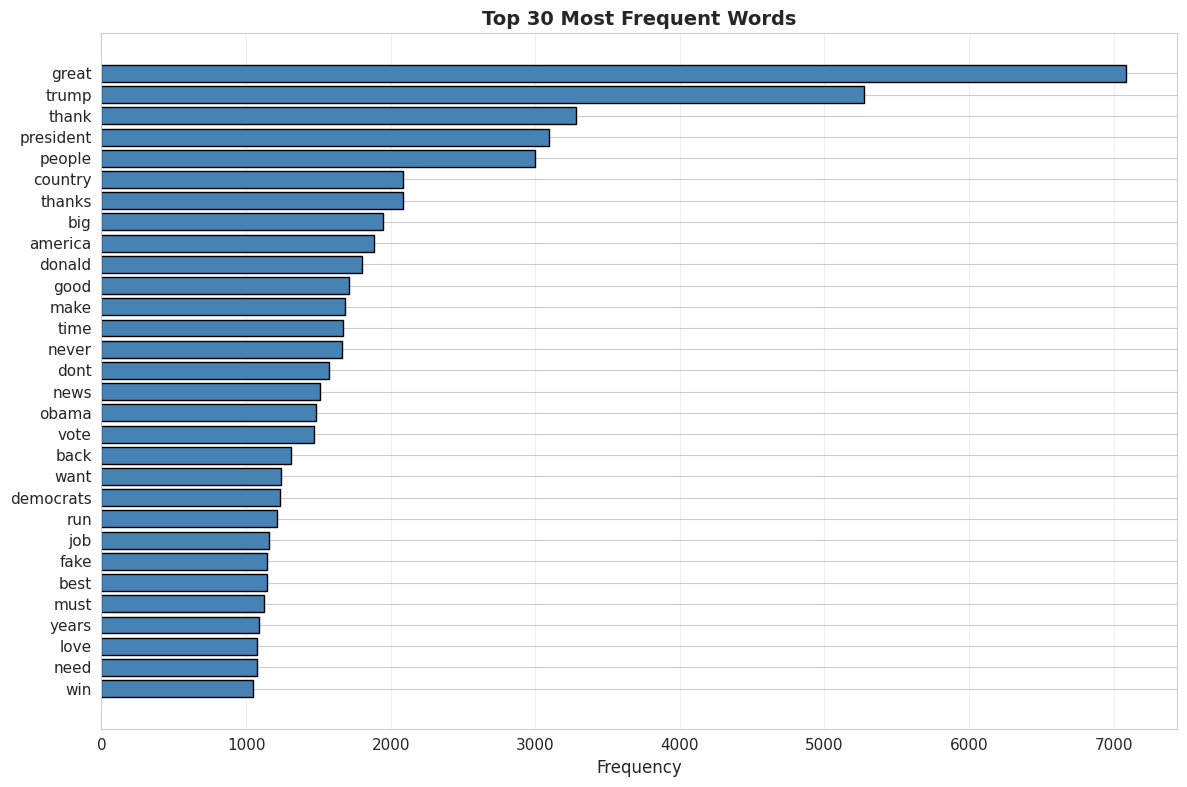

In [9]:
stats = {
    'Total Tweets': f"{len(df):,}",
    'Date Range': f"{df['date'].min().date()} → {df['date'].max().date()}",
    'Total Words': f"{df['word_count'].sum():,}",
    'Unique Words': f"{len(set([w for tokens in df['cleaned_tokens'] for w in tokens])):,}",
    'Avg Words/Tweet': f"{df['word_count'].mean():.1f}",
    'Median Words/Tweet': f"{df['word_count'].median():.0f}",
    'Total Favorites': f"{df['favorites'].sum():,}",
    'Total Retweets': f"{df['retweets'].sum():,}",
    'Avg Favorites': f"{df['favorites'].mean():.0f}",
    'Avg Retweets': f"{df['retweets'].mean():.0f}"
}

for key, value in stats.items():
    print(f"{key:.<40} {value:>20}")

# %%
# Temporal distribution
print("\n Tweets by Period:")
print(df['period'].value_counts().sort_index())

print("\n Tweets by Year:")
print(df['year'].value_counts().sort_index())

# %% [markdown]
# ###  Most Frequent Words (RQ1)

# %%
# Collect all words
all_words = [word for tokens in df['cleaned_tokens'] for word in tokens]
word_freq = Counter(all_words)
top_50_words = word_freq.most_common(50)

print("\n" + "="*80)
print("TOP 50 MOST FREQUENT WORDS")
print("="*80)
print(f"{'Rank':<6} {'Word':<20} {'Count':>10} {'% of Total':>12}")
print("-"*80)

total_words = len(all_words)
for rank, (word, count) in enumerate(top_50_words, 1):
    pct = (count / total_words) * 100
    print(f"{rank:<6} {word:<20} {count:>10,} {pct:>11.2f}%")

# %%
# Word Cloud
wordcloud = WordCloud(
    width=1200,
    height=600,
    background_color='white',
    max_words=100,
    colormap='RdYlBu',
    relative_scaling=0.5
).generate(' '.join(all_words))

plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Trump Tweets - Top 100 Words', fontsize=20, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('outputs/visualizations/wordcloud.png', dpi=300, bbox_inches='tight')
plt.show()

# %%
# Top words bar chart
words_df = pd.DataFrame(top_50_words[:30], columns=['word', 'count'])

plt.figure(figsize=(12, 8))
plt.barh(range(len(words_df)), words_df['count'], color='steelblue', edgecolor='black')
plt.yticks(range(len(words_df)), words_df['word'])
plt.xlabel('Frequency', fontsize=12)
plt.title('Top 30 Most Frequent Words', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('outputs/visualizations/top_words_bar.png', dpi=300, bbox_inches='tight')
plt.show()



#  5️. Word-Level Clustering (RQ2)

#  Methodology: Word2Vec + K-Means

 **Approach:**
 1. Train Word2Vec on all tokens (context-aware embeddings)
 2. Apply K-Means clustering (15 clusters)
 3. Visualize with t-SNE dimensionality reduction
 4. Interpret clusters manually

WORD-LEVEL CLUSTERING

 Training Word2Vec model...
 Vocabulary size: 4,910 words

 K-Means clustering (15 clusters)...

DISCOVERED WORD CLUSTERS

 CLUSTER 0:
   Total words: 240
   Top 15: republican, party, poll, joe, wow, democrat, debate, presidential, lost, polls, gop, candidate, bush, failed, cruz

 CLUSTER 1:
   Total words: 241
   Top 15: looking, forward, soon, maga, white, tomorrow, makeamericagreatagain, washington, florida, speech, yesterday, join, carolina, iowa, pennsylvania

 CLUSTER 2:
   Total words: 615
   Top 15: people, country, big, make, time, never, obama, back, want, years, win, go, way, done, election

 CLUSTER 3:
   Total words: 246
   Top 15: think, work, keep, every, success, life, important, find, entrepreneurs, successful, luck, focus, art, makes, champion

 CLUSTER 4:
   Total words: 271
   Top 15: via, national, golf, course, beautiful, top, hotel, city, tower, building, scotland, chicago, star, nyc, doral

 CLUSTER 5:
   Total words: 307
   Top 15: thank

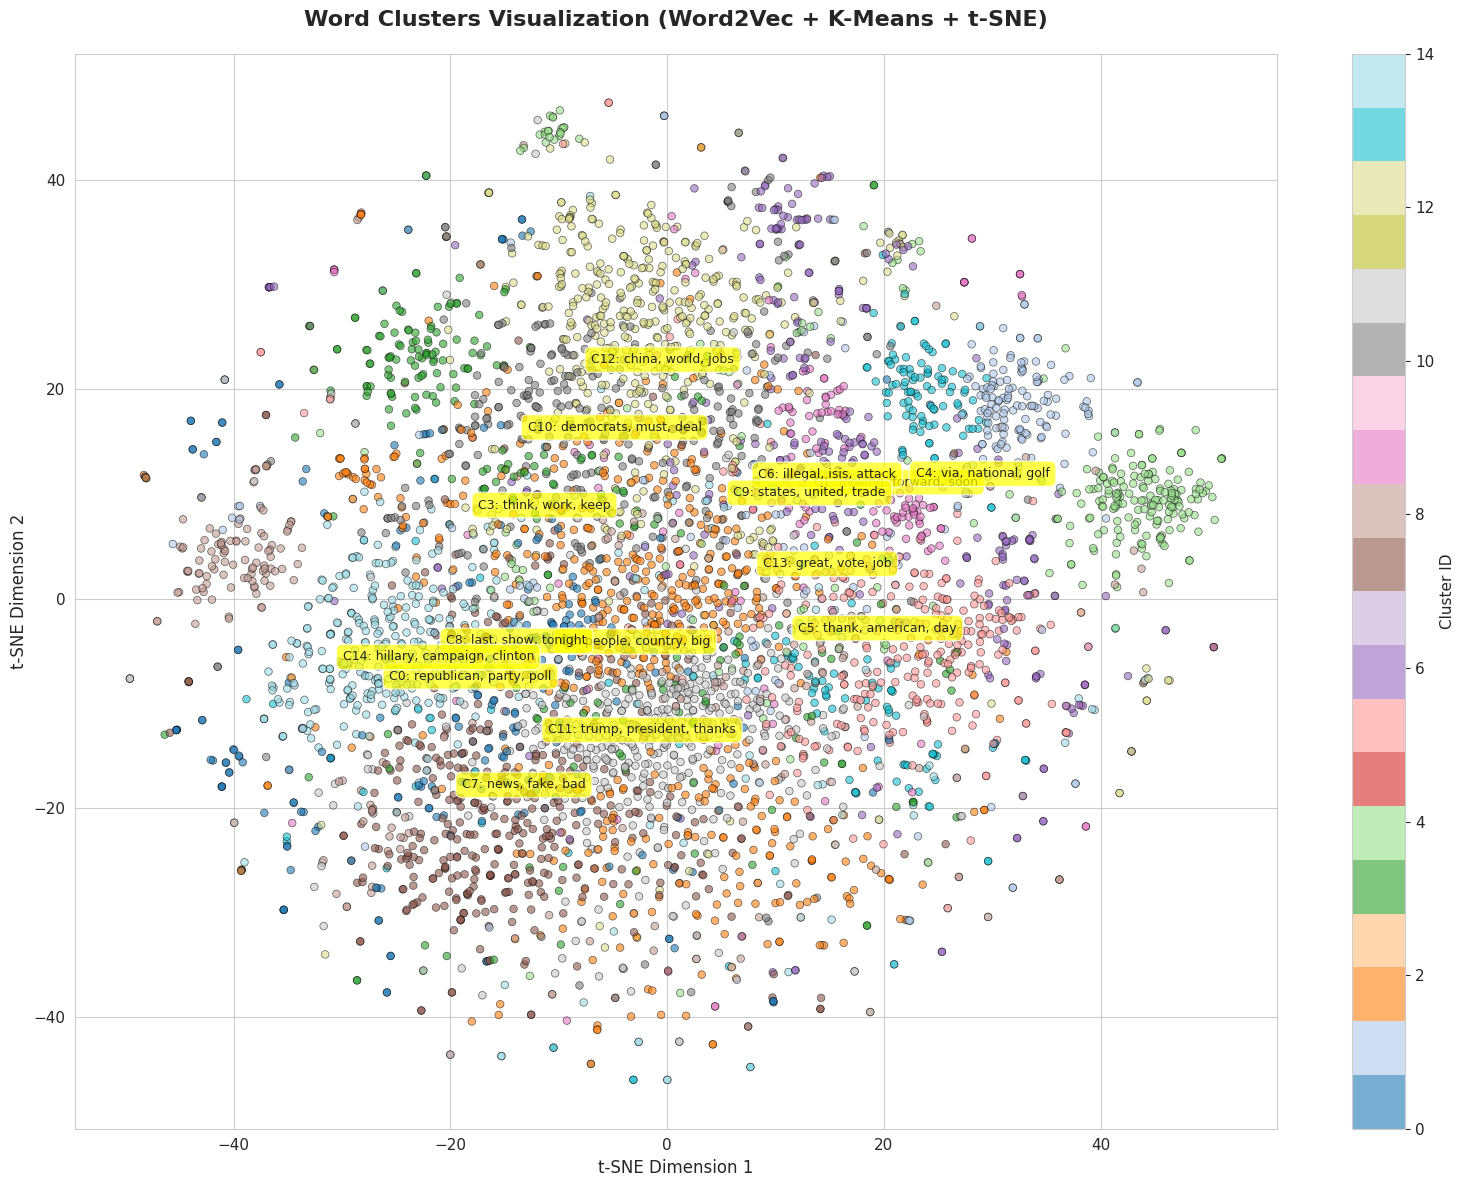

 Categories assigned to word clusters!

Cluster → Category Mapping:
  Cluster  0 → Media Delegitimization
  Cluster  1 → External Threats / Immigration
  Cluster  2 → Economic Populism
  Cluster  3 → Conspiracy Narratives
  Cluster  4 → National Identity
  Cluster  5 → Law & Order
  Cluster  6 → Under Attack / Victimization
  Cluster  7 → Legitimacy Questioning
  Cluster  8 → Polarization Techniques
  Cluster  9 → Charismatic Leadership
  Cluster 10 → Anti-Intellectualism
  Cluster 11 → Moral Superiority
  Cluster 12 → Crisis Exaggeration
  Cluster 13 → Friend-Enemy Logic
  Cluster 14 → Sole Representation


In [10]:
# Train Word2Vec
w2v_model = Word2Vec(
    sentences=df['cleaned_tokens'].tolist(),
    vector_size=100,
    window=5,
    min_count=10,
    workers=4,
    epochs=20,
    sg=1  # Skip-gram
)

vocab = list(w2v_model.wv.index_to_key)
print(f" Vocabulary size: {len(vocab):,} words")

# %%
# K-Means Clustering
print("\n K-Means clustering (15 clusters)...")

word_vectors = np.array([w2v_model.wv[word] for word in vocab])

kmeans = KMeans(n_clusters=15, random_state=42, n_init=20, max_iter=500)
cluster_labels = kmeans.fit_predict(word_vectors)

# Create mappings
word_clusters = {vocab[i]: cluster_labels[i] for i in range(len(vocab))}
cluster_words = defaultdict(list)

for word, cluster in word_clusters.items():
    cluster_words[cluster].append(word)


cluster_data = []

for cluster_id in range(15):
    words = cluster_words[cluster_id]

    # Get word frequencies
    word_freqs = {word: w2v_model.wv.get_vecattr(word, "count") for word in words}
    sorted_words = sorted(word_freqs.items(), key=lambda x: x[1], reverse=True)[:20]

    words_str = ', '.join([w[0] for w in sorted_words[:15]])

    print(f"\n CLUSTER {cluster_id}:")
    print(f"   Total words: {len(words)}")
    print(f"   Top 15: {words_str}")

    # Store for CSV
    for word, freq in sorted_words:
        cluster_data.append({
            'cluster_id': cluster_id,
            'word': word,
            'frequency': freq,
            'rank_in_cluster': sorted_words.index((word, freq)) + 1
        })

# Save word clusters
cluster_df = pd.DataFrame(cluster_data)
cluster_df.to_csv('data/processed/word_clusters.csv', index=False)

# %%
# t-SNE Visualization
print("\n Creating t-SNE visualization...")

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
coords = tsne.fit_transform(word_vectors)

plt.figure(figsize=(16, 12))
scatter = plt.scatter(
    coords[:, 0], coords[:, 1],
    c=cluster_labels,
    cmap='tab20',
    alpha=0.6,
    s=30,
    edgecolors='black',
    linewidth=0.5
)

# Annotate cluster centers
for cluster_id in range(15):
    mask = cluster_labels == cluster_id
    center_x = coords[mask, 0].mean()
    center_y = coords[mask, 1].mean()

    # Top 3 words
    top_words = [w[0] for w in sorted(
        [(word, w2v_model.wv.get_vecattr(word, "count"))
         for word in cluster_words[cluster_id]],
        key=lambda x: x[1], reverse=True
    )[:3]]

    label = f"C{cluster_id}: {', '.join(top_words)}"

    plt.annotate(
        label,
        xy=(center_x, center_y),
        fontsize=9,
        bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
        ha='center'
    )

plt.colorbar(scatter, label='Cluster ID')
plt.title('Word Clusters Visualization (Word2Vec + K-Means + t-SNE)',
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)
plt.tight_layout()
plt.savefig('outputs/visualizations/word_clusters_tsne.png', dpi=300, bbox_inches='tight')
plt.show()

# Save model
w2v_model.save('outputs/models/word2vec_model.model')

# %% [markdown]
# ### 🏷️ Manual Cluster Labeling
#
# Based on top words, assign populism categories:

# %%
# MANUAL MAPPING (adjust based on your results!)
cluster_to_category = {
    0: "Media Delegitimization",
    1: "External Threats / Immigration",
    2: "Economic Populism",
    3: "Conspiracy Narratives",
    4: "National Identity",
    5: "Law & Order",
    6: "Under Attack / Victimization",
    7: "Legitimacy Questioning",
    8: "Polarization Techniques",
    9: "Charismatic Leadership",
    10: "Anti-Intellectualism",
    11: "Moral Superiority",
    12: "Crisis Exaggeration",
    13: "Friend-Enemy Logic",
    14: "Sole Representation"
}

# Add to cluster dataframe
cluster_df['category'] = cluster_df['cluster_id'].map(cluster_to_category)
cluster_df.to_csv('data/processed/word_clusters.csv', index=False)

print(" Categories assigned to word clusters!")
print("\nCluster → Category Mapping:")
for cid, cat in cluster_to_category.items():
    print(f"  Cluster {cid:2d} → {cat}")

# BERTopic with Stopword Removal & Better Parameters
Training BERTopic model with enhanced configuration


⏳ Step 1/3: Generating embeddings...
⏳ Step 2/3: Processing results...

 BERTopic trained successfully!
   Discovered topics: 106
   Outliers (topic -1): 15,638 (34.8%)

  STILL HIGH OUTLIER RATE (34.8%)
   Recommendations:
   - Dataset may be too diverse
   - Consider reducing min_cluster_size further (currently 50)
   - Or accept outliers as 'uncategorizable' tweets

⏳ Step 3/3: Reducing topics (merging similar ones)...
   Topics after reduction: 14
DISCOVERED TWEET TOPICS (IMPROVED)

 TOPIC 0:
   Tweets: 8,166
   Keywords: course(0.143), miss(0.098), nbc(0.078), 2016(0.073), ratings(0.043), usa(0.040), congrats(0.033), sign(0.032), morning(0.032), opening(0.031), leader(0.031), winner(0.030), view(0.030), speak(0.029), winning(0.028)

 TOPIC 1:
   Tweets: 6,487
   Keywords: make america(0.091), honor(0.090), military(0.085), make america great(0.083), crowd(0.062), iowa(0.058), ohio(0.052), florida(0.049), join(0.047), virginia(0.046), north(0.044), whitehouse(0.040), mike(0.037), 

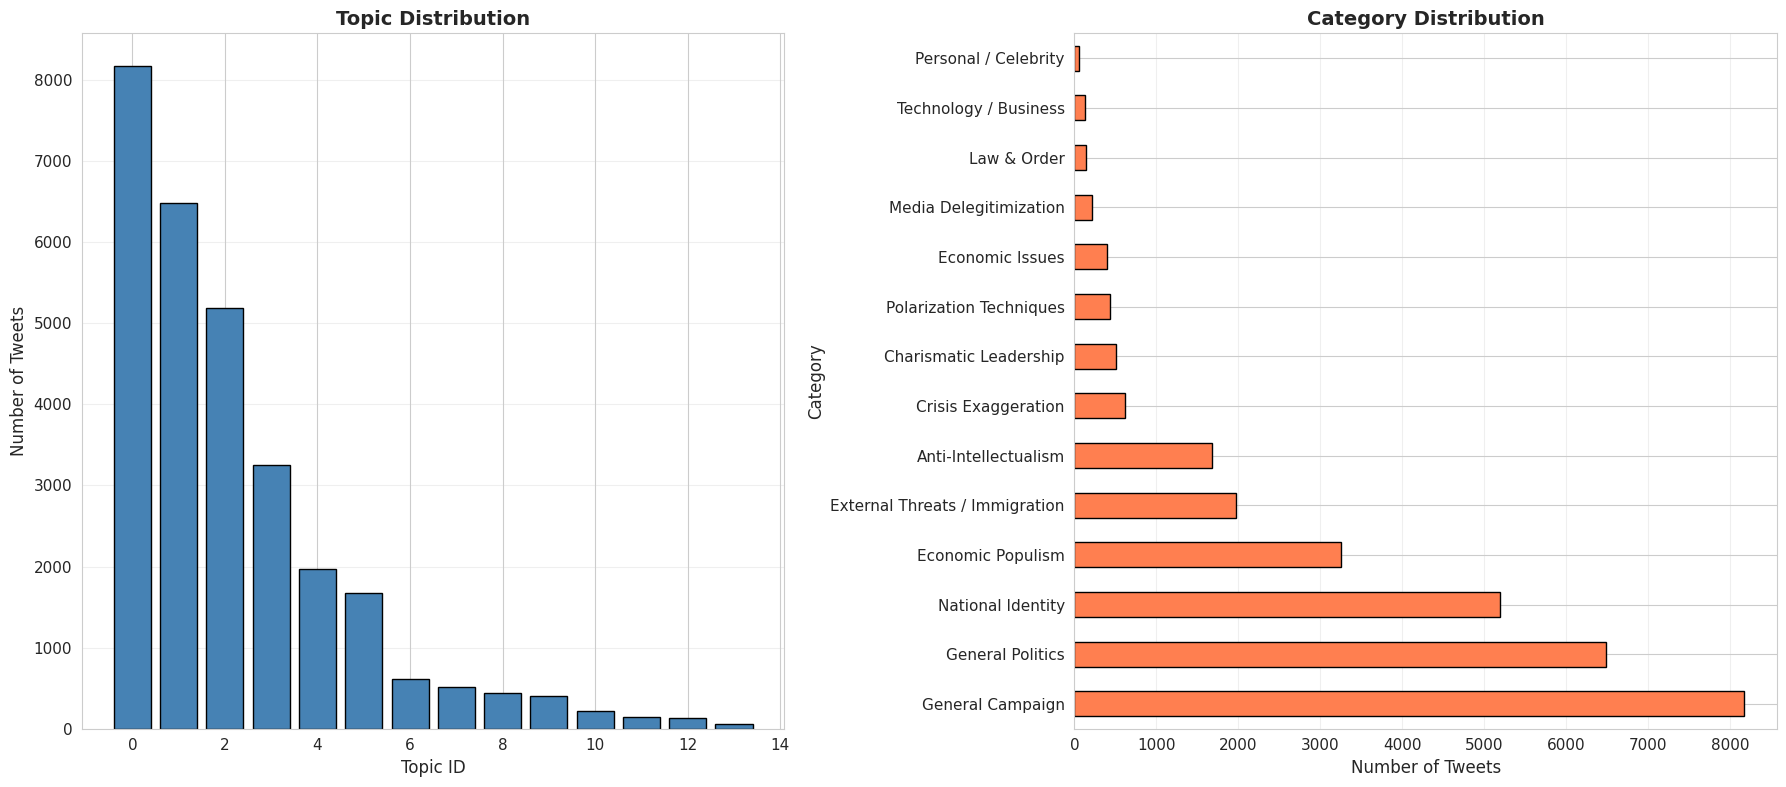

2025-12-07 18:20:41,830 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


In [12]:

from sklearn.feature_extraction.text import CountVectorizer

# 1. Custom CountVectorizer with stopwords removal
custom_stopwords = list(set(stopwords.words('english'))) + [
    # Add custom stopwords
    'https', 'http', 'co', 'rt', 'amp', 'realdonaldtrump', 'trump',
    'will', 'just', 'like', 'get', 'going', 'thank', 'thanks', 'you',
    'the', 'and', 'to', 'of', 'is', 'in', 'for', 'on', 'that', 'are',
    'it', 'with', 'be', 'was', 'as', 'at', 'this', 'from', 'they',
    'we', 'have', 'has', 'had', 'do', 'does', 'did', 'but', 'if',
    'or', 'an', 'my', 'your', 'their', 'our', 'he', 'she', 'his', 'her'
]

vectorizer_model = CountVectorizer(
    ngram_range=(1, 3),  # Unigrams, bigrams, trigrams
    stop_words=custom_stopwords,
    min_df=10,  # Word must appear in at least 10 documents
    max_df=0.7  # Ignore words appearing in >70% of documents
)

# 2. Better UMAP configuration (for dimensionality reduction)
from umap import UMAP
umap_model = UMAP(
    n_neighbors=15,
    n_components=5,
    min_dist=0.0,
    metric='cosine',
    random_state=42
)

# 3. Better HDBSCAN configuration (for clustering)
from hdbscan import HDBSCAN
hdbscan_model = HDBSCAN(
    min_cluster_size=50,  # INCREASED from 30 (fewer outliers)
    min_samples=10,       # Minimum samples in neighborhood
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True
)

# 4. Sentence Transformer
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

# 5. BERTopic with custom components
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    nr_topics='auto',  # Let BERTopic decide optimal number
    top_n_words=15,
    language='english',
    calculate_probabilities=True,
    verbose=False
)


try:
    print("\n Step 1/3: Generating embeddings...")
    topics, probs = topic_model.fit_transform(df['text_original'].tolist())

    print(" Step 2/3: Processing results...")

    # Add to dataframe
    df['topic_id'] = topics

    if probs is not None:
        df['topic_probability'] = probs.max(axis=1)
    else:
        df['topic_probability'] = 1.0

    # Statistics
    unique_topics = set(topics)
    outlier_count = sum(1 for t in topics if t == -1)
    actual_topics = len(unique_topics) - (1 if -1 in unique_topics else 0)
    outlier_pct = (outlier_count / len(topics)) * 100 if len(topics) > 0 else 0

    print("\n BERTopic trained successfully!")
    print(f"   Discovered topics: {actual_topics}")
    print(f"   Outliers (topic -1): {outlier_count:,} ({outlier_pct:.1f}%)")

    # Quality checks
    if outlier_pct > 30:
        print(f"\n  STILL HIGH OUTLIER RATE ({outlier_pct:.1f}%)")
        print("   Recommendations:")
        print("   - Dataset may be too diverse")
        print("   - Consider reducing min_cluster_size further (currently 50)")
        print("   - Or accept outliers as 'uncategorizable' tweets")
    elif outlier_pct < 10:
        print(f"\n Excellent outlier rate ({outlier_pct:.1f}%)")
    else:
        print(f"\n Good outlier rate ({outlier_pct:.1f}%)")

    print("\n Step 3/3: Reducing topics (merging similar ones)...")

    # Reduce topics to target number (optional)
    if actual_topics > 15:
        topic_model.reduce_topics(df['text_original'].tolist(), nr_topics=15)
        topics = topic_model.topics_
        df['topic_id'] = topics

        # Recalculate stats
        unique_topics = set(topics)
        actual_topics = len(unique_topics) - (1 if -1 in unique_topics else 0)
        print(f"   Topics after reduction: {actual_topics}")

except Exception as e:
    print(f"\n Error training BERTopic: {e}")
    import traceback
    traceback.print_exc()
    raise


print("DISCOVERED TWEET TOPICS (IMPROVED)")

topic_info = topic_model.get_topic_info()

for _, row in topic_info.iterrows():
    topic_id = row['Topic']
    if topic_id == -1:
        continue

    count = row['Count']
    topic_words = topic_model.get_topic(topic_id)

    if topic_words:
        # Filter out remaining stopwords (backup)
        filtered_words = [
            (word, score) for word, score in topic_words
            if word not in custom_stopwords and len(word) > 2
        ]
        words_str = ', '.join([f"{word}({score:.3f})" for word, score in filtered_words[:15]])
    else:
        words_str = "No words found"

    print(f"\n TOPIC {topic_id}:")
    print(f"   Tweets: {count:,}")
    print(f"   Keywords: {words_str}")

# %%
# ALTERNATIVE: Topic representation with c-TF-IDF top words
print("\n" + "="*80)
print("TOP CHARACTERISTIC WORDS PER TOPIC")
print("="*80)

# Get representative documents
for topic_id in sorted([t for t in set(topics) if t != -1])[:10]:
    # Get documents in this topic
    topic_docs = df[df['topic_id'] == topic_id]['cleaned_text'].tolist()

    if topic_docs:
        # Word frequency in this topic
        topic_words = ' '.join(topic_docs).split()
        word_freq = Counter(topic_words).most_common(20)

        # Filter stopwords
        filtered = [w for w, c in word_freq if w not in custom_stopwords and len(w) > 2][:10]

        count = len(topic_docs)
        print(f"\nTopic {topic_id} ({count:,} tweets): {', '.join(filtered)}")

# %%
# Representative tweets per topic
print("\n" + "="*80)
print("REPRESENTATIVE TWEETS BY TOPIC")
print("="*80)

valid_topics = sorted([t for t in set(topics) if t != -1])[:8]  # Show 8 topics

for topic_id in valid_topics:
    topic_tweets = df[df['topic_id'] == topic_id].nlargest(3, 'topic_probability')

    if len(topic_tweets) > 0:
        print(f"\n TOPIC {topic_id}:")
        for idx, row in topic_tweets.iterrows():
            print(f"   [{row['topic_probability']:.3f}] {row['text_original'][:120]}...")


print("MANUAL TOPIC CATEGORIZATION")


# Get actual topic IDs
actual_topic_ids = sorted([t for t in set(topics) if t != -1])
print(f"\nActual topic IDs: {actual_topic_ids}")
print(f"Total valid topics: {len(actual_topic_ids)}")

# Define mapping based on YOUR results above!
# IMPORTANT: Review the topic keywords and representative tweets
# Then assign appropriate category labels

topic_to_category = {}

# Example mapping
if len(actual_topic_ids) >= 14:
    topic_to_category = {
        0: "General Campaign",  # Adjust based on actual topic 0 content
        1: "General Politics",  # Adjust based on actual topic 1 content
        2: "National Identity",
        3: "Economic Populism",
        4: "External Threats / Immigration",
        5: "Anti-Intellectualism",
        6: "Crisis Exaggeration",
        7: "Charismatic Leadership",
        8: "Polarization Techniques",
        9: "Economic Issues",
        10: "Media Delegitimization",
        11: "Law & Order",
        12: "Technology / Business",
        13: "Personal / Celebrity",
    }
else:
    # If fewer topics, create mapping dynamically
    category_names = [
        "Media Delegitimization",
        "External Threats / Immigration",
        "Economic Populism",
        "Conspiracy Narratives",
        "National Identity",
        "Law & Order",
        "Under Attack / Victimization",
        "Legitimacy Questioning",
        "Polarization Techniques",
        "Charismatic Leadership",
        "Anti-Intellectualism",
        "Moral Superiority",
        "Crisis Exaggeration",
        "Friend-Enemy Logic",
        "Sole Representation"
    ]

    topic_to_category = {
        topic_id: category_names[i % len(category_names)]
        for i, topic_id in enumerate(actual_topic_ids)
    }

# Map categories
df['topic_category'] = df['topic_id'].map(topic_to_category)
df['topic_category'] = df['topic_category'].fillna('Outlier')

print("\n Categories assigned!")

# Show mapping
print("\nTopic → Category Mapping:")
for topic_id in actual_topic_ids:
    category = topic_to_category.get(topic_id, "UNMAPPED")
    count = (df['topic_id'] == topic_id).sum()
    pct = (count / len(df)) * 100
    print(f"  Topic {topic_id:2d} → {category:35s} {count:6,} ({pct:5.1f}%)")

# Outliers
outlier_count_df = (df['topic_id'] == -1).sum()
outlier_pct_df = (outlier_count_df / len(df)) * 100
print(f"\n  Outliers → {'Outlier':35s} {outlier_count_df:6,} ({outlier_pct_df:5.1f}%)")


print("FINAL CATEGORY DISTRIBUTION")


category_counts = df['topic_category'].value_counts()
print("\nTweets by Category:")
for category, count in category_counts.items():
    pct = (count / len(df)) * 100
    bar = "█" * int(pct / 2)
    print(f"{category:35s} {count:6,} ({pct:5.1f}%) {bar}")

# %%
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Topic distribution (exclude outliers)
topic_counts = df[df['topic_id'] != -1]['topic_id'].value_counts().sort_index()
if len(topic_counts) > 0:
    axes[0].bar(topic_counts.index, topic_counts.values, color='steelblue', edgecolor='black')
    axes[0].set_xlabel('Topic ID', fontsize=12)
    axes[0].set_ylabel('Number of Tweets', fontsize=12)
    axes[0].set_title('Topic Distribution', fontsize=14, fontweight='bold')
    axes[0].grid(axis='y', alpha=0.3)

# Category distribution (exclude outliers)
category_counts_no_outlier = category_counts[category_counts.index != 'Outlier']
if len(category_counts_no_outlier) > 0:
    category_counts_no_outlier.plot(kind='barh', ax=axes[1], color='coral', edgecolor='black')
    axes[1].set_xlabel('Number of Tweets', fontsize=12)
    axes[1].set_ylabel('Category', fontsize=12)
    axes[1].set_title('Category Distribution', fontsize=14, fontweight='bold')
    axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/visualizations/improved_topic_distribution.png', dpi=300, bbox_inches='tight')
print("\n Saved: outputs/visualizations/improved_topic_distribution.png")
plt.show()

# %%
# Save improved model
try:
    topic_model.save('outputs/models/bertopic_model_improved')
except Exception as e:
    print(f"⚠️  Could not save model: {e}")

